### Dataset

### Import Library

In [1]:
from torchvision import transforms
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np

### Import dataset

In [2]:
import os
os.environ["KAGGLEHUB_CACHE_DIR"] = "C:/Users/fianc/Documents/Project/ML/data"

import kagglehub

path = kagglehub.dataset_download("dheerajperumandla/drowsiness-dataset")
path_pred = kagglehub.dataset_download("adinishad/prediction-images")
print("Path to dataset files:", path)
print("Path to prediction images:", path_pred)

c:\Users\fianc\Documents\BootcampAI\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\fianc\.cache\kagglehub\datasets\dheerajperumandla\drowsiness-dataset\versions\1
Path to prediction images: C:\Users\fianc\.cache\kagglehub\datasets\adinishad\prediction-images\versions\9


### Preprocessing
Label

In [3]:
labels = os.listdir("C:/Users/fianc/.cache/kagglehub/datasets/dheerajperumandla/drowsiness-dataset/versions/1/train")
labels

['Closed', 'no_yawn', 'Open', 'yawn']

Cek gambar

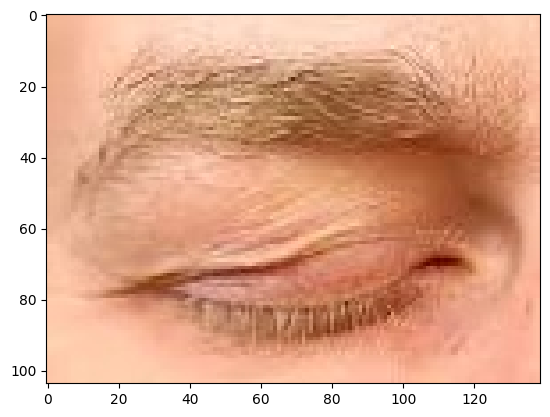

In [4]:
plt.imshow(plt.imread("C:/Users/fianc/.cache/kagglehub/datasets/dheerajperumandla/drowsiness-dataset/versions/1/train/Closed/_30.jpg"))

In [5]:
a = plt.imread("C:/Users/fianc/.cache/kagglehub/datasets/dheerajperumandla/drowsiness-dataset/versions/1/train/yawn/32.jpg")
a.shape

(480, 640, 3)

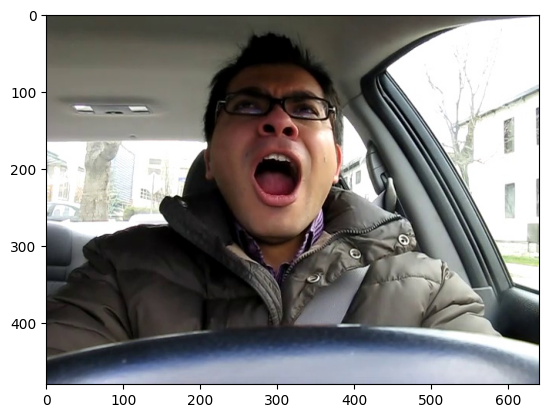

In [6]:
plt.imshow(plt.imread("C:/Users/fianc/.cache/kagglehub/datasets/dheerajperumandla/drowsiness-dataset/versions/1/train/yawn/32.jpg"))

Daerah untuk yawn

In [7]:
def face_for_yawn(direc="C:/Users/fianc/.cache/kagglehub/datasets/dheerajperumandla/drowsiness-dataset/versions/1/train", 
                  face_cas_path="C:/Users/fianc/.cache/kagglehub/datasets/adinishad/prediction-images/versions/9/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 64 # mengurangi ukuran gambar untuk efisiensi
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


Daerah untuk open eye

In [8]:
def get_data(dir_path="C:/Users/fianc/.cache/kagglehub/datasets/dheerajperumandla/drowsiness-dataset/versions/1/train", 
             face_cas="C:/Users/fianc/.cache/kagglehub/datasets/adinishad/prediction-images/versions/9/haarcascade_frontalface_default.xml", 
             eye_cas="C:/Users/fianc/.cache/kagglehub/datasets/adinishad/prediction-images/versions/9/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 64 # mengurangi ukuran gambar untuk efisiensi
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data


data_train = get_data()

2
3


In [9]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    # Separate images and labels
    images = [item[0] for item in yaw_no]
    labels = [item[1] for item in yaw_no]
    # Stack images into a 4D array
    images_array = np.stack(images)
    labels_array = np.array(labels)
    return images_array, labels_array

new_images, new_labels = append_data()

0
1
2
3


In [10]:
X = []
y = []

for image in new_images:
    X.append(image)

for label in new_labels:
    y.append(label)

In [11]:
X = np.array(X)
X = X.reshape(-1, 64, 64, 3)

In [12]:
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [13]:
y = np.array(y)

In [14]:
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [15]:
len(X_test)

578

In [16]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
tf.__version__

'2.19.0'

In [18]:
keras.__version__

'3.10.0'

### Data Augmentation

In [19]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

### Feature Extraction

In [59]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [60]:
model = Sequential()
model.add(resnet_base)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [61]:
for layer in resnet_base.layers:
    layer.trainable = False

In [62]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001  # You can change this value
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [ ]:
# model = Sequential()

# model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
# model.add(MaxPooling2D(2, 2))

# model.add(Conv2D(128, (3, 3), activation="relu"))
# model.add(MaxPooling2D(2, 2))

# model.add(Conv2D(64, (3, 3), activation="relu"))
# model.add(MaxPooling2D(2, 2))

# model.add(Conv2D(32, (3, 3), activation="relu"))
# model.add(MaxPooling2D(2, 2))

# model.add(Flatten())
# model.add(Dropout(0.5))

# model.add(Dense(64, activation="relu"))
# model.add(Dense(4, activation="softmax"))

# model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# model.summary()

AttributeError: 'Functional' object has no attribute 'add'

### Training

In [63]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.4172 - loss: 1.2462 - val_accuracy: 0.5969 - val_loss: 1.0022
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.5616 - loss: 0.9713 - val_accuracy: 0.6332 - val_loss: 0.8782
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.6526 - loss: 0.8230 - val_accuracy: 0.6851 - val_loss: 0.7870
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.7083 - loss: 0.7533 - val_accuracy: 0.7111 - val_loss: 0.7008
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.7444 - loss: 0.6295 - val_accuracy: 0.6955 - val_loss: 0.6850
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.7396 - loss: 0.6141 - val_accuracy: 0.7405 - val_loss: 0.6054
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7922 - loss: 0.5341 - val_accuracy: 0.8028 - val_loss: 0.5780
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7808 - loss: 0.5453 - val_accuracy: 0

In [25]:
for layer in resnet_base.layers:
    layer.trainable = True

Cek akurasi

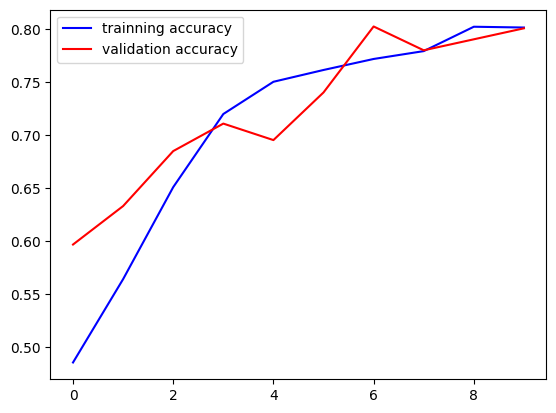

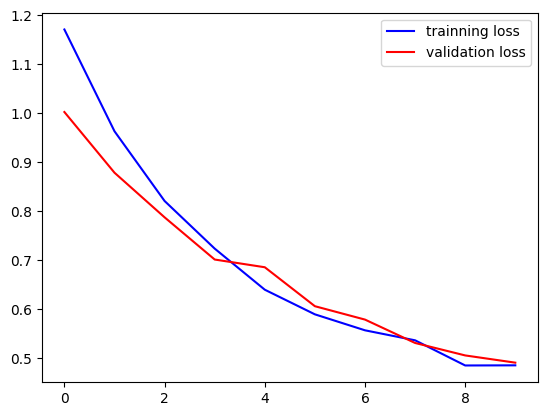

In [64]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [65]:
model.save("drowiness_new6.h5.keras")

In [66]:
model.save("drowiness_new6.model.keras")

In [27]:
learning_rate = 0.0001  # Lower learning rate for fine-tuning
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [28]:
history_fine_tune = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 76s 820ms/step - accuracy: 0.6729 - loss: 1.0261 - val_accuracy: 0.0917 - val_loss: 2.4402
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 732ms/step - accuracy: 0.9184 - loss: 0.2106 - val_accuracy: 0.3910 - val_loss: 6.1007
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 776ms/step - accuracy: 0.9538 - loss: 0.1180 - val_accuracy: 0.3910 - val_loss: 20.8378
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 830ms/step - accuracy: 0.9522 - loss: 0.1342 - val_accuracy: 0.3910 - val_loss: 31.6299
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 801ms/step - accuracy: 0.9671 - loss: 0.0847 - val_accuracy: 0.3910 - val_loss: 21.9563
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 768ms/step - accuracy: 0.9767 - loss: 0.0645 - val_accuracy: 0.1176 - val_loss: 29.4091
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 836ms/step - accuracy: 0.9794 - loss: 0.0589 - val_accuracy: 0.1107 - val_loss: 66.2344
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 710ms/step - accuracy: 0.9862 - loss: 0.0355 - val

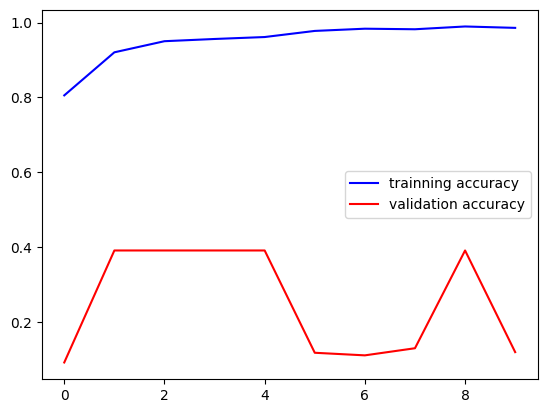

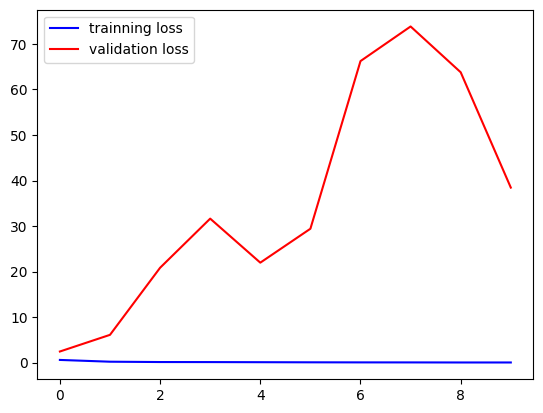

In [29]:
accuracy = history_fine_tune.history['accuracy']
val_accuracy = history_fine_tune.history['val_accuracy']
loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [30]:
train_pixel_intensities = []
test_pixel_intensities = []

for image in X_train:
    train_pixel_intensities.extend(image.flatten())

for image in X_test:
    test_pixel_intensities.extend(image.flatten())

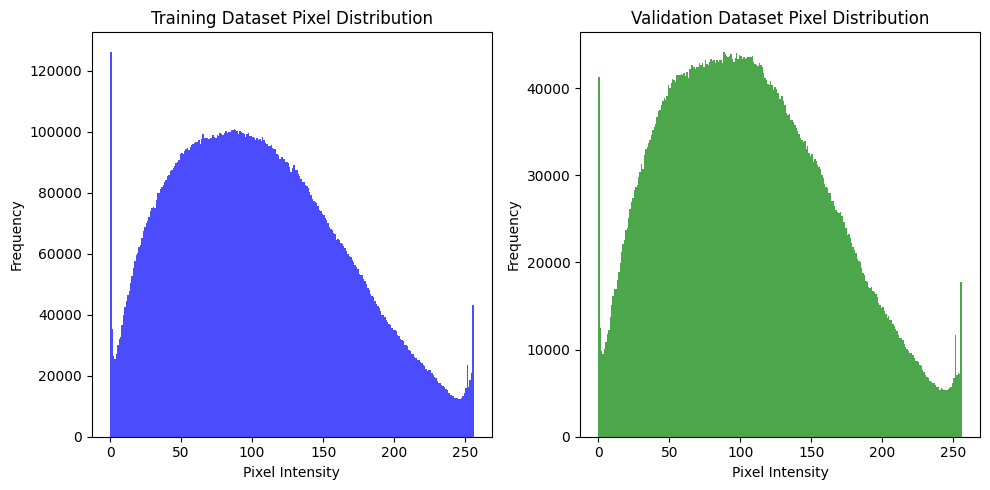

In [31]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(train_pixel_intensities, bins=256, range=[0, 256], color='blue', alpha=0.7)
plt.title('Training Dataset Pixel Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_pixel_intensities, bins=256, range=[0, 256], color='green', alpha=0.7)
plt.title('Validation Dataset Pixel Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [32]:
learning_rate = 0.001  # You can change this value
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [33]:
history_fine_tune_2 = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 89s 988ms/step - accuracy: 0.8674 - loss: 0.7408 - val_accuracy: 0.3910 - val_loss: 577.0799
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 902ms/step - accuracy: 0.9376 - loss: 0.1801 - val_accuracy: 0.3720 - val_loss: 32.3753
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 859ms/step - accuracy: 0.9670 - loss: 0.1086 - val_accuracy: 0.6540 - val_loss: 1.5596
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 726ms/step - accuracy: 0.9597 - loss: 0.1061 - val_accuracy: 0.3945 - val_loss: 16.8990
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 659ms/step - accuracy: 0.9592 - loss: 0.1283 - val_accuracy: 0.7007 - val_loss: 1.0129
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 657ms/step - accuracy: 0.9713 - loss: 0.0976 - val_accuracy: 0.5917 - val_loss: 1.9901
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 656ms/step - accuracy: 0.9696 - loss: 0.0743 - val_accuracy: 0.7682 - val_loss: 0.6505
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 652ms/step - accuracy: 0.9825 - loss: 0.0657 - val_

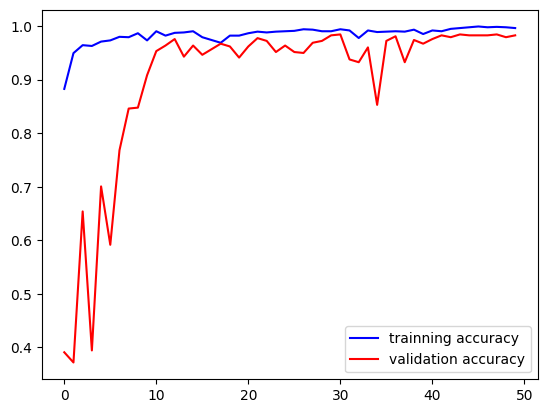

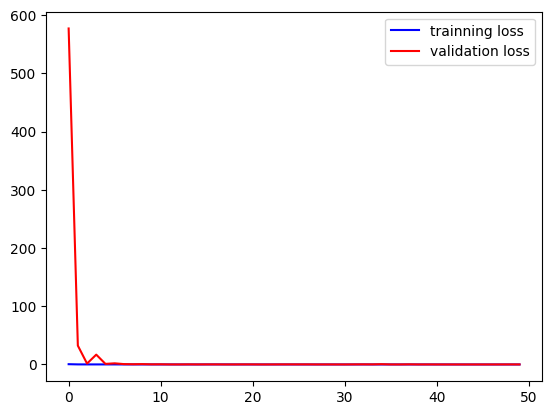

In [34]:
accuracy = history_fine_tune_2.history['accuracy']
val_accuracy = history_fine_tune_2.history['val_accuracy']
loss = history_fine_tune_2.history['loss']
val_loss = history_fine_tune_2.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
#model.save("drowiness_new6.h5.keras")

In [ ]:
#model.save("drowiness_new6.model.keras")

### Prediction

In [67]:
prediction = model.predict(X_test)
prediction_classes = np.argmax(prediction, axis=1)
prediction_classes

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,

In [68]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [69]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction_classes, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.50      0.62      0.55        63
     no_yawn       0.00      0.00      0.00        74
      Closed       0.42      0.95      0.58       215
        Open       0.50      0.02      0.03       226

    accuracy                           0.43       578
   macro avg       0.35      0.40      0.29       578
weighted avg       0.40      0.43      0.29       578



c:\Users\fianc\Documents\BootcampAI\myenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\fianc\Documents\BootcampAI\myenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\fianc\Documents\BootcampAI\myenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

In [70]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 64
def prepare(filepath, face_cas="C:/Users/fianc/.cache/kagglehub/datasets/adinishad/prediction-images/versions/9/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255.0
    face_cascade = cv2.CascadeClassifier(face_cas)
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5.keras")

In [71]:
prediction = model.predict([prepare("C:/Users/fianc/.cache/kagglehub/datasets/dheerajperumandla/drowsiness-dataset/versions/1/train/yawn/_101.jpg")])
np.argmax(prediction)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'